In [ ]:
import os
import sys

HOME_DIR = r'D:\Swinburne\COS40007 - Artificial Intelligence for Engineering'
os.chdir(HOME_DIR)

DATASETS_DIR = f'{HOME_DIR}/datasets'
DATA_DIR = f'{DATASETS_DIR}/coroision/coroision_train'
NO_RUST_DATASET_FOLDER = f'{DATA_DIR}/no_rust'
RUST_DATASET_FOLDER = f'{DATA_DIR}/rust'
TEST_DIR = f'{DATASETS_DIR}/coroision/coroision_test'
LOG_LABEL_DATASET_FOLDER = f'{DATASETS_DIR}/coroision/log-labelled'
COCO_ANNOTATIONS_DIR = f'{DATASETS_DIR}/coroision/coco_annotations'

MY_LOG_LABEL_DATASET_FOLDER = f'{DATASETS_DIR}/corision/my-log-labelled'
MY_COCO_ANNOTATIONS_DIR = f'{DATASETS_DIR}/coroision/my_coco_annotations'

os.makedirs(TEST_DIR, exist_ok=True)
os.makedirs(f'{TEST_DIR}/no_rust', exist_ok=True)
os.makedirs(f'{TEST_DIR}/rust', exist_ok=True)
os.makedirs(COCO_ANNOTATIONS_DIR, exist_ok=True)
os.makedirs(MY_COCO_ANNOTATIONS_DIR, exist_ok=True)

print(f'HOME_DIR: {HOME_DIR}')
print(f'DATASETS_DIR: {DATASETS_DIR}')
print(f'DATA_DIR: {DATA_DIR}')
print(f'RUST_DATASET_FOLDER: {RUST_DATASET_FOLDER}')
print(f'NO_RUST_DATASET_FOLDER: {NO_RUST_DATASET_FOLDER}')
print(f'COCO_ANNOTATIONS_DIR: {COCO_ANNOTATIONS_DIR}')


In [ ]:
%pip install --upgrade pip --quiet
%pip install -r requirements.txt --quiet

In [3]:
import os
import platform
import random
import shutil

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.utils import draw_bounding_boxes, save_image

import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import torchvision.transforms.functional as F

import labelme2coco
from pycocotools.coco import COCO

import pandas as pd

In [ ]:
if platform.system() == 'Darwin':
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Task 1: Develop CNN and Resnet50

In [ ]:
# Load and check dataset labels
dataset = ImageFolder(DATA_DIR)
print("Classes:", dataset.classes)
print("Class to index mapping:", dataset.class_to_idx)

# Check if the labels are correct
labels = [label for _, label in dataset]
print("Unique labels in the dataset:", set(labels))

In [ ]:
# Data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load training dataset (only rust and no_rust)
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# Load test dataset from the separate test directory
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Verify the classes and label indices
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")
print(f"Classes in training set: {train_dataset.classes}")
print(f"Classes in test set: {test_dataset.classes}")

In [ ]:
# Visualize a random image from the training + test
def visualize_sample(dataset, dataset_name="Dataset"):
    """
    Visualize a single random image from the given dataset.
    
    Parameters:
    - dataset: The dataset to select the image from (train/test dataset).
    - dataset_name: A string indicating the dataset's name (e.g., "Train Dataset" or "Test Dataset").
    """
    # Randomly select an image and its label from the dataset
    img_idx = random.randint(0, len(dataset) - 1)
    img, label = dataset[img_idx]
    
    # Convert the image tensor back to a PIL image for display
    img = F.to_pil_image(img)
    
    # Get the class name from the dataset
    class_name = dataset.classes[label]

    # Plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"{dataset_name} - Class: {class_name}")
    plt.axis("off")
    plt.show()

# Visualize a random image from the training + test
visualize_sample(train_dataset, dataset_name="Train Dataset")
visualize_sample(test_dataset, dataset_name="Test Dataset")

## Simple CNN

In [ ]:
# Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)  # Output layer for 2 classes: rust and no_rust

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 32 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
simplecnn = SimpleCNN()
simplecnn.to(device)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(simplecnn.parameters(), lr=0.001)

print("SimpleCNN model initialized.")

In [ ]:
# Training the simple CNN model
num_epochs = 10
for epoch in range(num_epochs):
    simplecnn.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = simplecnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')


# Save the trained model
torch.save(simplecnn.state_dict(), 'Portfolios/Portfolio05/models/simple_cnn.pth')

print("Training complete. Model saved as 'Portfolios/Portfolio05/models/simple_cnn.pth'.")

In [ ]:
# Evaluation
simplecnn = SimpleCNN()
simplecnn.load_state_dict(torch.load('Portfolios/Portfolio05/models/simple_cnn.pth'))
simplecnn.to(device)

simplecnn.eval()
correct = 0
total = 0
results = []

# Create output folder
os.makedirs('Portfolios/Portfolio05/cnn_test', exist_ok=True)

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        outputs = simplecnn(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

        # Save and visualize each test image with prediction
        for j in range(images.size(0)):
            true_class = labels[j].item()
            predicted_class = predicted[j].item()

            image_path = os.path.join('Portfolios/Portfolio05/cnn_test', f"image_{i}_{j}_true_{true_class}_pred_{predicted_class}.png")
            save_image(images[j], image_path)

            # Add the result to the results list for creating a table
            results.append({"True Class": true_class, "Predicted Class": predicted_class})

            # Visualize the image
            plt.figure(figsize=(6, 6))
            plt.imshow(images[j].cpu().permute(1, 2, 0))
            plt.title(f"True: {true_class}, Predicted: {predicted_class}")
            plt.axis('off')
            plt.show()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the Simple CNN model on the test set: {accuracy:.2f}%')

# Create a Pandas DataFrame for the results
df = pd.DataFrame(results)

# Save the table as a CSV file
df.to_csv('Portfolios/Portfolio05/cnn_test/cnn_test_results.csv', index=False)

# Display the table of results
print(df)

# Save results to text file
with open('Portfolios/Portfolio05/cnn_test/cnn_test_results.txt', 'w') as f:
    for _, row in df.iterrows():
        f.write(f"True: {row['True Class']}, Predicted: {row['Predicted Class']}\n")
    f.write(f"\nFinal Accuracy: {accuracy:.2f}%\n")

print("Test results saved to 'Portfolio05/cnn_test/cnn_test_results.txt' and 'cnn_test_results.csv'.")

## Resnet50

In [11]:
# Training the ResNet50 model
# Load the pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 2)  # Adjust the final layer for 2 classes: rust and no_rust

# Use the same loss function and optimizer
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

resnet50.to(device)
# Training the ResNet50 model
for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Save the ResNet50 model
torch.save(resnet50.state_dict(), 'Portfolios/Portfolio05/models/resnet50.pth')

print("ResNet50 model training complete. Model saved as 'Portfolios/Portfolio05/models/resnet50.pth'.")

Epoch 2/10, Loss: 0.0850
Epoch 3/10, Loss: 0.0850
Epoch 4/10, Loss: 0.0013
Epoch 5/10, Loss: 0.0024
Epoch 6/10, Loss: 0.0006
Epoch 7/10, Loss: 0.0002
Epoch 8/10, Loss: 0.0002
Epoch 9/10, Loss: 0.0002
Epoch 10/10, Loss: 0.0001
ResNet50 model training complete. Model saved as 'Portfolios/Portfolio05/models/resnet50.pth'.


C:\Users\Admin\AppData\Local\Temp\ipykernel_14304\636536490.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50.load_state_dict(torch.load('Portfolios/Portfolio05/m

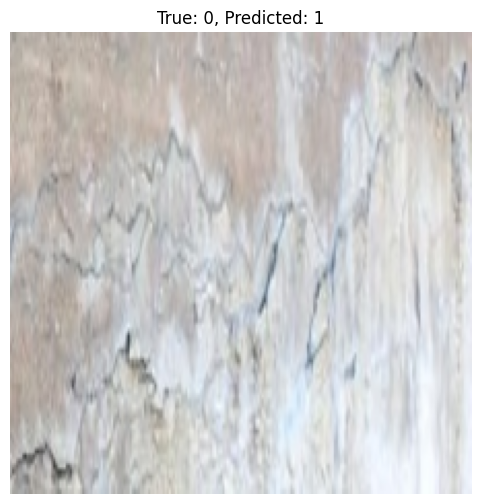

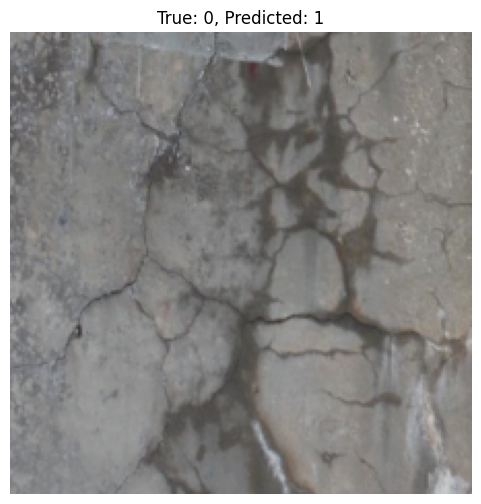

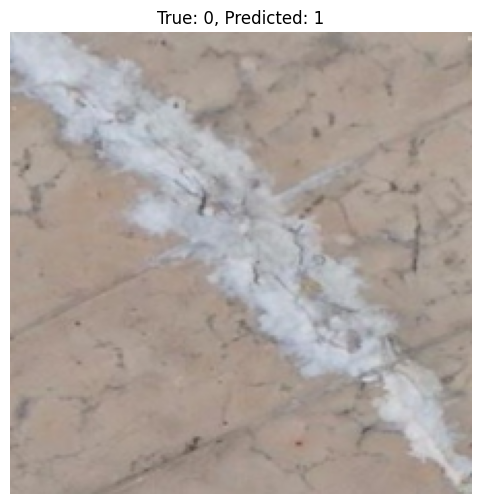

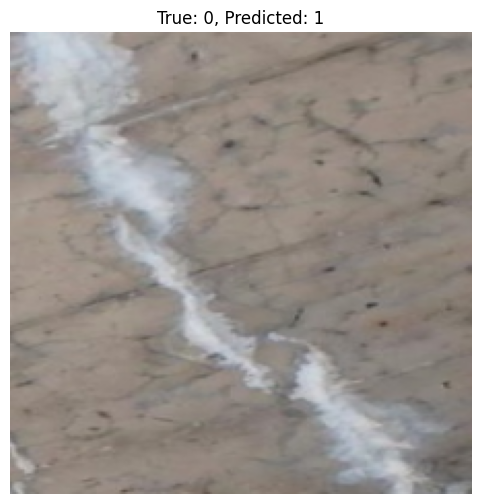

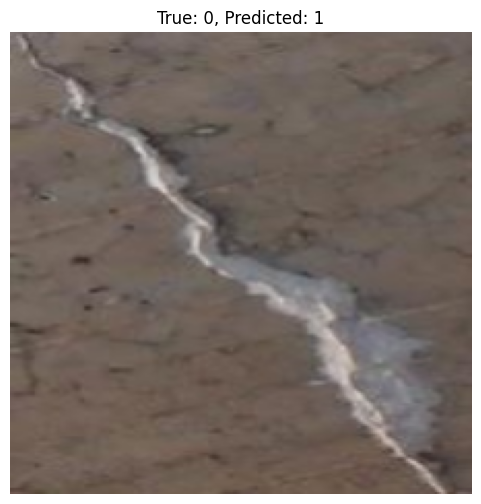

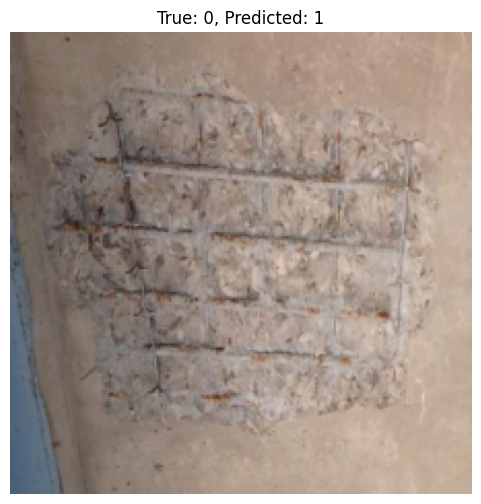

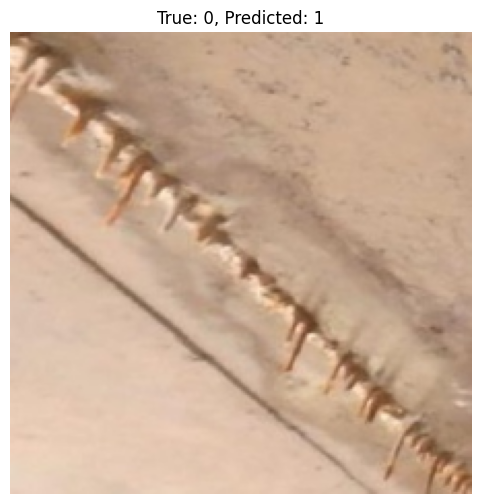

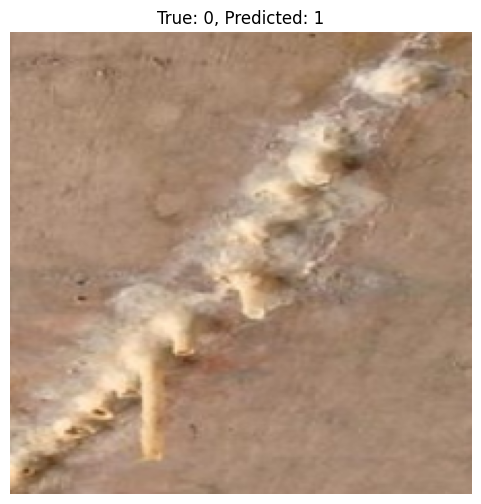

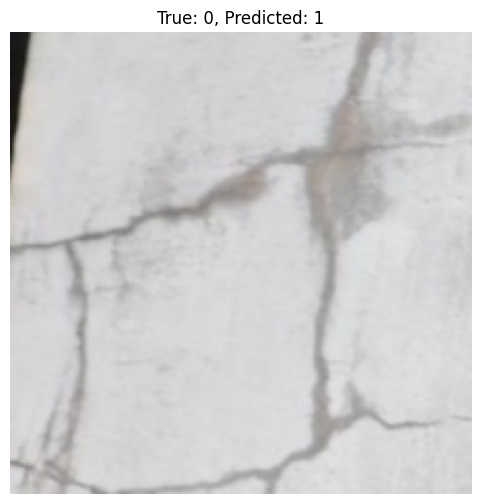

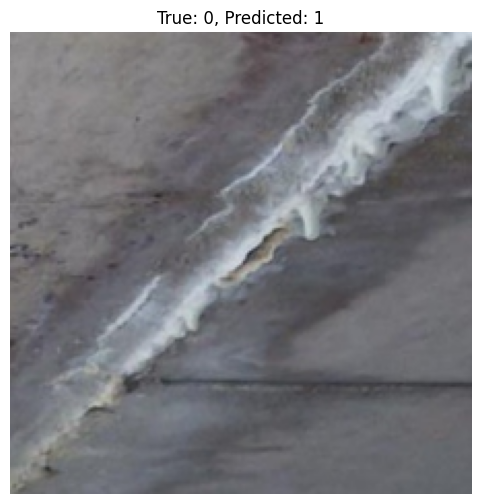

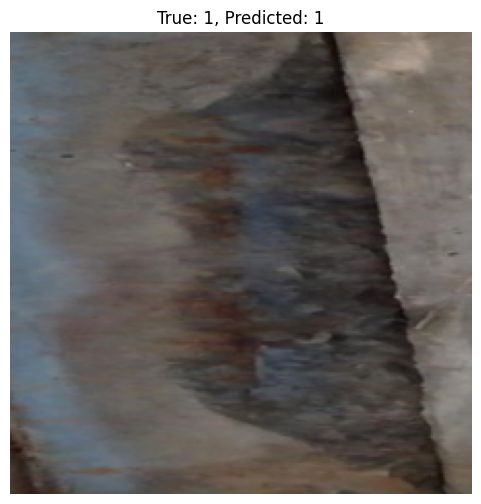

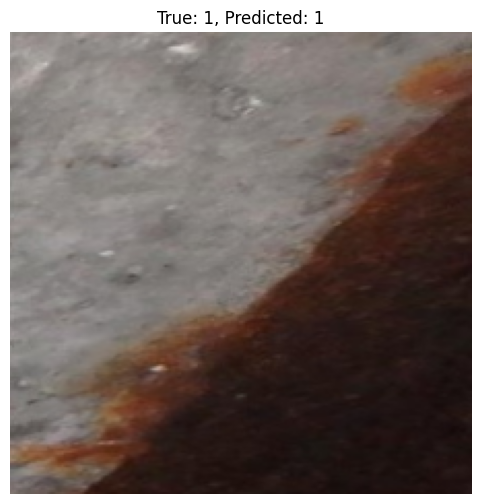

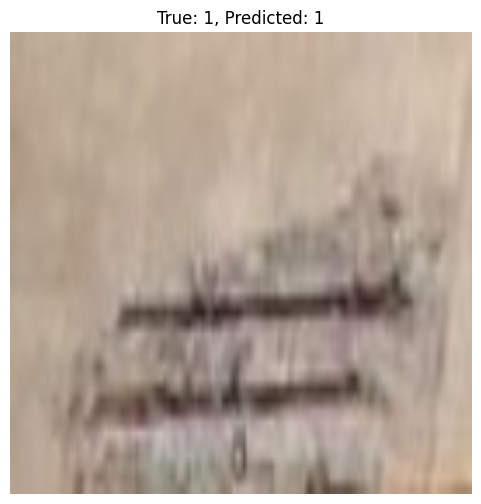

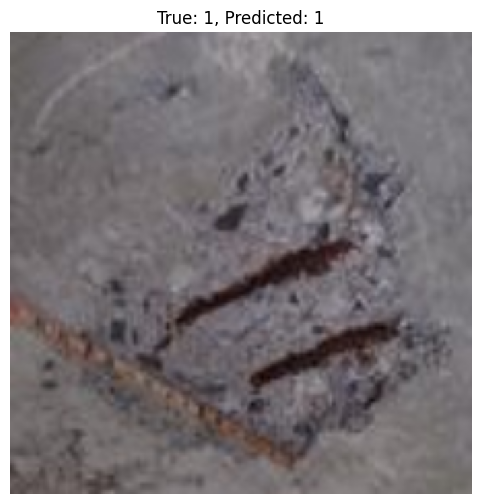

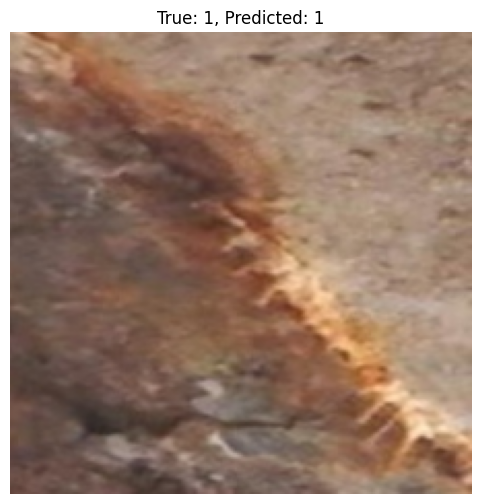

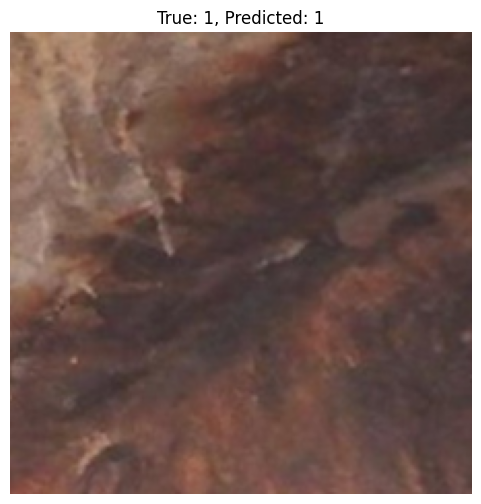

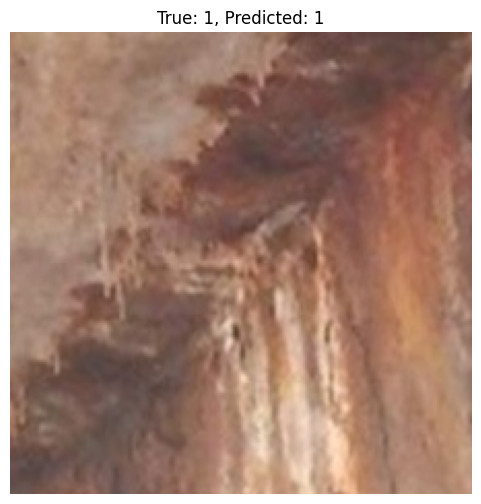

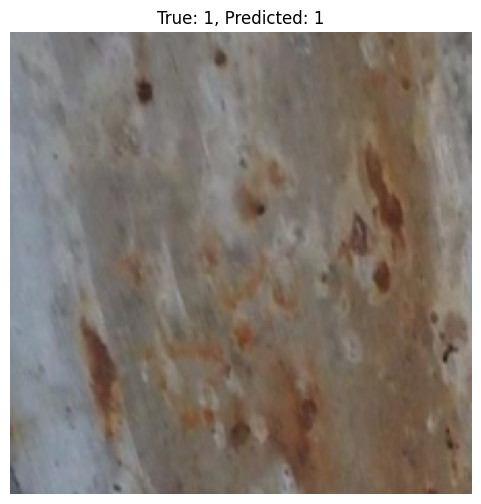

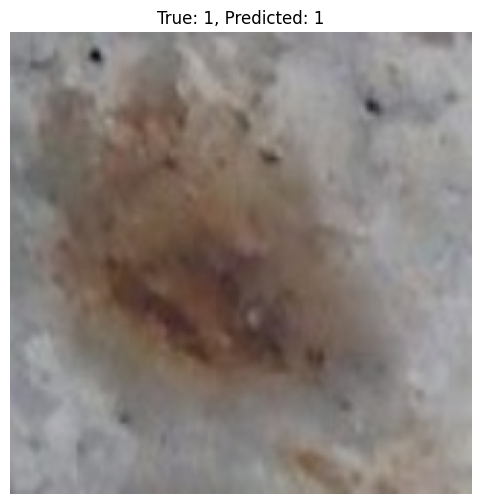

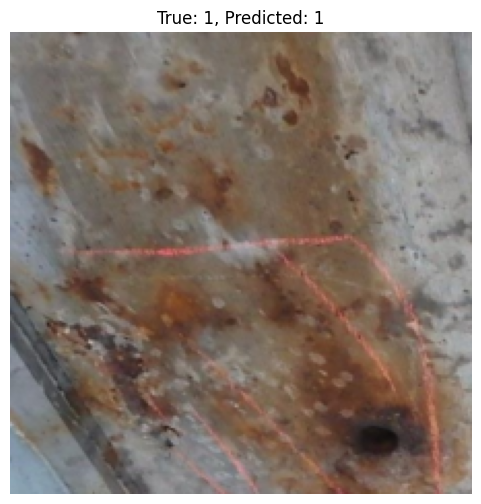

Accuracy of the ResNet50 model on the test set: 50.00%
    True Class  Predicted Class
0            0                1
1            0                1
2            0                1
3            0                1
4            0                1
5            0                1
6            0                1
7            0                1
8            0                1
9            0                1
10           1                1
11           1                1
12           1                1
13           1                1
14           1                1
15           1                1
16           1                1
17           1                1
18           1                1
19           1                1
Test results saved to 'Portfolios/Portfolio05/resnet50_test/resnet50_test_results.txt' and 'resnet50_test_results.csv'.


In [12]:
# Evaluation
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 2)  # 2 classes (rust, no_rust)
resnet50.load_state_dict(torch.load('Portfolios/Portfolio05/models/resnet50.pth'))
resnet50.to(device)

resnet50.eval()
correct = 0
total = 0
results = []

# Create output folder
os.makedirs('Portfolios/Portfolio05/resnet50_test', exist_ok=True)

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        outputs = resnet50(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

        # Save and visualize each test image with prediction
        for j in range(images.size(0)):
            true_class = labels[j].item()
            predicted_class = predicted[j].item()

            image_path = os.path.join('Portfolios/Portfolio05/resnet50_test', f"image_{i}_{j}_true_{true_class}_pred_{predicted_class}.png")
            save_image(images[j], image_path)

            # Add the result to the results list for creating a table
            results.append({"True Class": true_class, "Predicted Class": predicted_class})

            # Visualize the image
            plt.figure(figsize=(6, 6))
            plt.imshow(images[j].cpu().permute(1, 2, 0))
            plt.title(f"True: {true_class}, Predicted: {predicted_class}")
            plt.axis('off')
            plt.show()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the ResNet50 model on the test set: {accuracy:.2f}%')

# Create a Pandas DataFrame for the results
df = pd.DataFrame(results)

# Save the table as a CSV file
df.to_csv('Portfolios/Portfolio05/resnet50_test/resnet50_test_results.csv', index=False)

# Display the table of results
print(df)

# Save results to text file
with open('Portfolios/Portfolio05/resnet50_test/resnet50_test_results.txt', 'w') as f:
    for _, row in df.iterrows():
        f.write(f"True: {row['True Class']}, Predicted: {row['Predicted Class']}\n")
    f.write(f"\nFinal Accuracy: {accuracy:.2f}%\n")

print("Test results saved to 'Portfolios/Portfolio05/resnet50_test/resnet50_test_results.txt' and 'resnet50_test_results.csv'.")

# Task 2: Develop Mask RCNN for detecting log

In [13]:
# Set directory
labelme_folder = LOG_LABEL_DATASET_FOLDER
export_dir = COCO_ANNOTATIONS_DIR

# Convert LabelMe annotations to COCO format
train_split_rate = 0.5  # 50% for training
category_id_start = 1  # Start category IDs from 1
labelme2coco.convert(labelme_folder, export_dir, train_split_rate, category_id_start=category_id_start)

print("LabelMe annotations converted to COCO format for log detection.")

There are 600 listed files in folder COS40007 - Artificial Intelligence for Engineering/datasets/coroision/log-labelled.


Converting labelme annotations to COCO format: 100%|██████████| 600/600 [00:02<00:00, 223.25it/s]
10/12/2024 14:18:23 - INFO - labelme2coco -   Training split in COCO format is exported to D:\Swinburne\COS40007 - Artificial Intelligence for Engineering\datasets\coroision\coco_annotations\train.json
10/12/2024 14:18:24 - INFO - labelme2coco -   Validation split in COCO format is exported to D:\Swinburne\COS40007 - Artificial Intelligence for Engineering\datasets\coroision\coco_annotations\val.json


LabelMe annotations converted to COCO format for log detection.


In [14]:
# Custom COCO dataset class
class COCODataset(Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        img_info = coco.loadImgs(img_id)[0]
        path = img_info['file_name']

        # Load image
        img_path = os.path.join(self.root, path)
        img = Image.open(img_path).convert('RGB')

        # Load annotations
        num_objs = len(anns)
        boxes = []
        labels = []
        masks = []

        for ann in anns:
            xmin = ann['bbox'][0]
            ymin = ann['bbox'][1]
            width = ann['bbox'][2]
            height = ann['bbox'][3]
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'])
            masks.append(coco.annToMask(ann))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks, axis=0), dtype=torch.uint8)

        image_id = torch.tensor([img_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)


In [15]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Paths to images and COCO annotations
images_dir = LOG_LABEL_DATASET_FOLDER
train_json = os.path.join(COCO_ANNOTATIONS_DIR, 'train.json')
val_json = os.path.join(COCO_ANNOTATIONS_DIR, 'val.json')

# Dataset instances
train_dataset = COCODataset(root=images_dir, annotation=train_json, transforms=transform)
val_dataset = COCODataset(root=images_dir, annotation=val_json, transforms=transform)

# Collate Function
def collate_fn(batch):
    return tuple(zip(*batch))

# DataLoader instances
train_loader = DataLoader(
    train_dataset,
    batch_size=32,       
    shuffle=True,
    num_workers=0,     
    collate_fn=collate_fn  
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,      
    shuffle=False,
    num_workers=0,      
    collate_fn=collate_fn  
)

print("Datasets loaded successfully for Mask R-CNN training.")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Datasets loaded successfully for Mask R-CNN training.


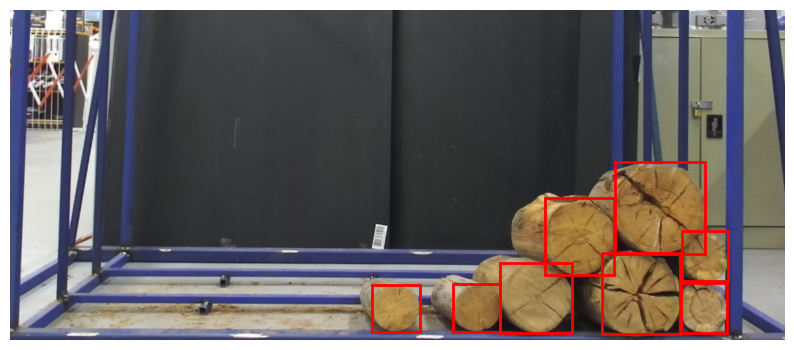

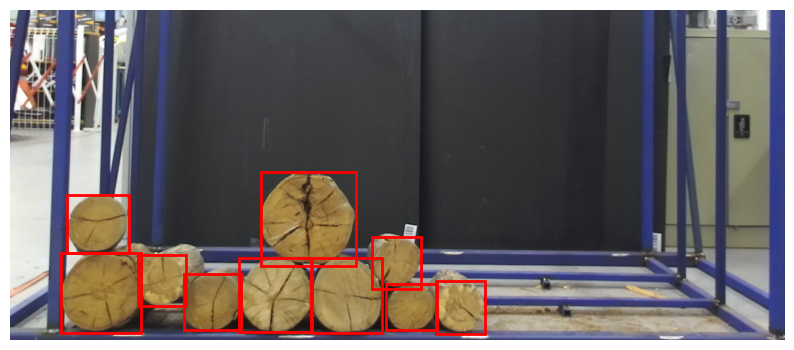

: 

In [16]:
# Visualize a sample from the COCO dataset
def visualize_sample(dataset, index=None):
    if index is None:
        index = random.randint(0, len(dataset) - 1)
    
    img, target = dataset[index]
    img = img.permute(1, 2, 0).numpy()
    
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()
    masks = target['masks'].numpy()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    
    ax = plt.gca()
    
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
    
    plt.axis('off')
    plt.show()

# Visualize a random training sample
visualize_sample(train_dataset)
visualize_sample(val_dataset)


In [ ]:
# Training the Mask R-CNN model
# Load Pe-trained Mask R-CNN model + ResNet-50-FPN backbone
num_classes = 2  # 1 class ('log') + background
maskrcnn = maskrcnn_resnet50_fpn(weights="DEFAULT")

# Match the number of classes (log + background) for Predictors
in_features = maskrcnn.roi_heads.box_predictor.cls_score.in_features
maskrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Match the number of classes for Mask Predictor
in_features_mask = maskrcnn.roi_heads.mask_predictor.conv5_mask.in_channels
maskrcnn.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)

# Load previous trained model (only if it exists) works for conitnuing training
model_path = 'Portfolios/Portfolio05/models/mask_rcnn_resnet50_log_detector.pth'
if os.path.exists(model_path):
    maskrcnn.load_state_dict(torch.load(model_path))
    print(f"Loaded pre-trained model from {model_path}")

maskrcnn.to(device)

#  Optimizer
params = [p for p in maskrcnn.parameters() if p.requires_grad]
optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Epochs
num_epochs = 10
total_steps = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    maskrcnn.train()
    running_loss = 0.0
    
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = maskrcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()
        total_steps += 1
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    lr_scheduler.step()

torch.save(maskrcnn.state_dict(), 'Portfolios/Portfolio05/models/mask_rcnn_resnet50_log_detector.pth')
print(f"Mask R-CNN with ResNet-50-FPN backbone model trained and saved.")

Epoch 1/10


In [ ]:
import time

time_start = time.time()

# Create output folder
os.makedirs('Portfolios/Portfolio05/rcnn_test', exist_ok=True)

def visualize_predictions(image, output, score_threshold=0.3, save_path=None):
    """
    Visualize predicted bounding boxes, masks, labels with confidence score threshold, and log count.
    """
    image = (image * 255).byte()  # Convert the image back to [0-255] range for visualization
    
    # Extract predicted bounding boxes, labels, scores, and masks
    pred_boxes = output['boxes'].cpu()
    pred_labels = output['labels'].cpu()
    pred_scores = output['scores'].cpu()
    pred_masks = output['masks'].cpu()

    # Filter predictions by confidence score
    high_conf_indices = pred_scores >= score_threshold
    pred_boxes = pred_boxes[high_conf_indices]
    pred_labels = pred_labels[high_conf_indices]
    pred_scores = pred_scores[high_conf_indices]
    pred_masks = pred_masks[high_conf_indices]

    # Count the number of logs
    log_count = (pred_labels == 1).sum().item()

    if len(pred_boxes) == 0:
        print("No boxes with confidence score above threshold.")
        return

    # Convert image tensor to PIL for drawing
    image_with_boxes_pil = F.to_pil_image(image)
    draw = ImageDraw.Draw(image_with_boxes_pil)

    # Define large font size and boldness
    try:
        font = ImageFont.truetype("arialbd.ttf", size=40)
    except IOError:
        font = ImageFont.load_default(size=40)

    # Draw bounding boxes and labels
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        xmin, ymin, xmax, ymax = box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
        label_text = f"Log {label.item()} ({score:.2f})"
        text_position = (xmin, ymin - 50) if ymin - 50 > 0 else (xmin, ymin + 5)
        draw.text(text_position, label_text, fill="white", font=font)

    # Convert back to tensor for mask overlay
    image_with_boxes = F.to_tensor(image_with_boxes_pil)

    # Create an overlay for the masks
    mask_overlay = np.zeros_like(np.array(image_with_boxes_pil), dtype=np.uint8)

    for mask in pred_masks:
        mask = mask.squeeze(0).numpy()
        mask = (mask * 255).astype(np.uint8)  # mask is uint8
        mask_overlay[:, :, 0] += mask  # Adding mask in the red channel for visualization

    # Plot the image with bounding boxes and masks
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image_with_boxes_pil)
    ax.imshow(mask_overlay, alpha=0.5, cmap='Reds')
    
    # Add title with larger, bold font
    ax.set_title(
        f"Threshold: {score_threshold * 100:.0f}%\nLog count: {log_count}", 
        fontsize=12, fontweight='bold'
    )
    plt.axis("off")

    # Save the image if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Validation loop and visualization
num_classes = 2  # 1 class ('log') + background
maskrcnn = maskrcnn_resnet50_fpn(weights="DEFAULT")
in_features = maskrcnn.roi_heads.box_predictor.cls_score.in_features
maskrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
in_features_mask = maskrcnn.roi_heads.mask_predictor.conv5_mask.in_channels
maskrcnn.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)
maskrcnn.load_state_dict(torch.load('Portfolios/Portfolio05/models/mask_rcnn_resnet50_log_detector.pth'))
maskrcnn.to(device)
maskrcnn.eval()
        
with torch.no_grad():
    for idx, (images, targets) in enumerate(val_loader):
        images = list(image.to(device) for image in images)
        outputs = maskrcnn(images)

        # Save and visualize the prediction outcome images
        save_path = os.path.join('Portfolios/Portfolio05/rcnn_test', f"image_{idx + 1}.png")
        visualize_predictions(images[0].cpu(), outputs[0], score_threshold=0.8, save_path=save_path)

        if idx + 1 == 10:  # Limit visualization to 10 samples
            break

time_end = time.time()
print(f"Validation and visualization completed in {time_end - time_start:.2f} seconds.")

# Task 3: Extending log labelling to another class.

In [ ]:
# Set directory
labelme_folder = MY_LOG_LABEL_DATASET_FOLDER
export_dir = MY_COCO_ANNOTATIONS_DIR

# Convert LabelMe annotations to COCO format
category_id_start = 1  # Start category IDs from 1
labelme2coco.convert(labelme_folder, export_dir, category_id_start=category_id_start)

print("LabelMe annotations converted to COCO format for log detection.")

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
images_dir = MY_LOG_LABEL_DATASET_FOLDER
dataset_json = os.path.join(MY_COCO_ANNOTATIONS_DIR, 'dataset.json')
dataset = COCODataset(root=images_dir, annotation=dataset_json, transforms=transform)
visualize_sample(dataset, index=0)